In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from rdflib import Graph
import numpy as np
import scipy

from pykeen.triples import TriplesFactory
import pykeen
from pykeen.pipeline import pipeline

import matplotlib.pyplot as plt

In [2]:
def load_dataset(path, name):
    triple_data = open(path + name).read().strip()
    data = np.array([triple.split(',') for triple in triple_data.split('\n')])
    tf_data = TriplesFactory.from_labeled_triples(triples=data)
    return tf_data, triple_data


def create_model(tf_training, tf_testing, embedding, n_epoch, path):
    results = pipeline(
        training=tf_training,
        testing=tf_testing,
        model=embedding,
        training_loop='sLCWA',
#         negative_sampler='bernoulli',
        negative_sampler_kwargs=dict(
        filtered=True,
        ),
        # Training configuration
        training_kwargs=dict(
            num_epochs=n_epoch,
            use_tqdm_batch=False,
        ),
        # Runtime configuration
        random_seed=1235,
        device='gpu',
    )
    model = results.model
    results.save_to_directory(path + embedding)
    return model, results


def get_learned_embeddings(model):
    entity_representation_modules: List['pykeen.nn.RepresentationModule'] = model.entity_representations
    relation_representation_modules: List['pykeen.nn.RepresentationModule'] = model.relation_representations

    entity_embeddings: pykeen.nn.Embedding = entity_representation_modules[0]
    relation_embeddings: pykeen.nn.Embedding = relation_representation_modules[0]

    entity_embedding_tensor: torch.FloatTensor = entity_embeddings()
    relation_embedding_tensor: torch.FloatTensor = relation_embeddings()
    return entity_embedding_tensor, relation_embedding_tensor


def create_dataframe_predicted_entities(entity_embedding_tensor, entity, training):
    df = pd.DataFrame(entity_embedding_tensor.cpu().detach().numpy())
    df['target'] = list(training.entity_to_id)
    new_df = df.loc[df.target.isin(list(entity))]
    return new_df.iloc[:, :-1], new_df, df


def cosine_sim(x, y):
    return abs(1 - scipy.spatial.distance.cosine(x, y))


def matrix_similarity(new_df, f_dist, th):
    array = new_df.set_index('target')
    entity = list(array.index.values)
    sim_matrix = pd.DataFrame(index=entity, columns=entity)
    sim_matrix = sim_matrix.fillna(0.0)
    list_sim = []

    for index, row in array.iterrows():
        for indexC, rowC in array.iterrows():
            sim = f_dist(row.values, rowC.values)
            sim = round(sim, 5)
            sim_matrix.at[index, indexC] = sim
            list_sim.append(sim)
    
    threshold = np.percentile(list_sim, th)
    print("percentil", threshold)
    #for col in sim_matrix.columns:
    #    sim_matrix.loc[sim_matrix[col] < threshold, [col]] = 0
    return sim_matrix, threshold


# === Save cosine similarity matrix with the structure SemEP need
def SemEP_structure(name, sim_matrix, sep):
    f = open(name, mode="w+")
    f.write(str(sim_matrix.shape[0]) + "\n")
    f.close()
    sim_matrix.to_csv(name, mode='a', sep=sep, index=False, header=False, float_format='%.5f')
    

def create_entitie(list_n, ENTITIES_FILE):
    entities = "\n".join(str(x) for x in list_n)
    n_ent = str(len(list_n))
    entity = open(ENTITIES_FILE, mode="w+")
    entity.write(n_ent + "\n" + entities)
    entity.close()

In [3]:
tf_data, triple_data = load_dataset('dataset/','country_ind.csv')

In [4]:
# triples = np.loadtxt('dataset/country_ind.csv', dtype=str, delimiter=",")
# tf = TriplesFactory.from_labeled_triples(triples)
training, testing = tf_data.split(random_state=1234)

In [5]:
testing

TriplesFactory(num_entities=267, num_relations=7, num_triples=244, inverse_triples=False)

In [6]:
training

TriplesFactory(num_entities=267, num_relations=7, num_triples=975, inverse_triples=False)

In [7]:
model, results = create_model(training, testing, 'TransE', 100, 'dataset/')

Training epochs on cuda:   0%|          | 0/100 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=244.


Evaluating on cuda:   0%|          | 0.00/244 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds


In [8]:
results.metric_results.to_df()

,Side,Type,Metric,Value
0,head,pessimistic,hits_at_1,0.000000
1,head,pessimistic,hits_at_3,0.024590
2,head,pessimistic,hits_at_5,0.032787
3,head,pessimistic,hits_at_10,0.077869
4,head,pessimistic,arithmetic_mean_rank,99.959016
...,...,...,...,...
136,both,optimistic,inverse_harmonic_mean_rank,0.124728
137,both,optimistic,inverse_median_rank,0.042553
138,both,optimistic,rank_std,65.842081
139,both,optimistic,rank_var,4335.179618


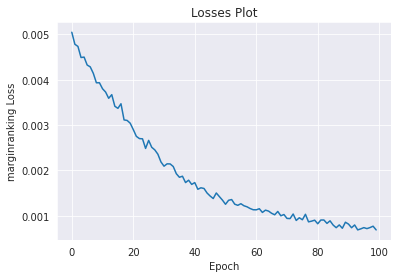

In [9]:
results.plot_losses()
plt.show()

In [10]:
entity_embedding_tensor, relation_embedding_tensor = get_learned_embeddings(model)
entity_embedding_tensor

tensor([[-0.1356,  0.0726,  0.1150,  ..., -0.0962, -0.2503, -0.0340],
        [-0.0738, -0.0603,  0.1276,  ..., -0.1002,  0.2311, -0.2461],
        [ 0.0846,  0.2611,  0.1941,  ...,  0.0708, -0.1910,  0.1721],
        ...,
        [-0.1615, -0.0433,  0.2059,  ..., -0.2418,  0.1749,  0.0364],
        [-0.1510, -0.0844,  0.2160,  ...,  0.1802,  0.0309,  0.0443],
        [-0.2765,  0.0719,  0.2179,  ..., -0.3003,  0.0573,  0.2365]],
       device='cuda:0', grad_fn=<ViewBackward>)

In [11]:
tf_dataset = pd.read_csv('dataset/country_ind.csv', delimiter=",")
entity = list(tf_dataset.country.unique())
df_predicted_entities, new_df, df_g1 = create_dataframe_predicted_entities(entity_embedding_tensor, entity, tf_data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
0,-0.135565,0.072556,0.115049,0.200108,0.253868,0.212039,-0.021585,-0.036807,-0.087690,0.184004,...,0.145176,-0.050802,0.029728,-0.094370,-0.042717,-0.154082,-0.096209,-0.250292,-0.034015,ABW
1,-0.073800,-0.060259,0.127550,-0.136825,0.044615,-0.070897,0.084930,-0.014609,0.011925,0.151541,...,-0.186251,-0.187177,0.153349,-0.231068,-0.140957,-0.234731,-0.100204,0.231062,-0.246076,AFE
2,0.084604,0.261067,0.194148,0.119360,-0.250155,-0.022727,-0.008397,-0.213987,-0.096121,0.103080,...,-0.237282,0.093671,0.156131,-0.030011,0.239360,0.026839,0.070789,-0.191035,0.172107,AFG
3,0.090168,-0.049328,-0.050143,0.124999,0.147375,0.187530,0.224349,-0.022015,-0.042085,-0.143121,...,-0.057939,-0.210356,0.252468,-0.136988,0.200476,-0.043720,0.082255,0.158667,-0.125933,AFW
4,-0.056203,-0.073061,0.021349,-0.084020,-0.188636,-0.095419,-0.283438,-0.202302,-0.105624,0.224979,...,-0.120047,0.247373,0.063829,0.201050,-0.050228,0.066647,-0.007136,0.142786,0.064511,AGO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,-0.089365,-0.102230,0.056013,0.019820,-0.066810,-0.009766,0.077275,-0.009309,-0.191329,-0.047161,...,-0.018858,0.001779,-0.251325,0.041015,-0.195910,0.143335,-0.197588,-0.165399,-0.049803,XKX
256,0.056900,0.003378,-0.170136,-0.123131,0.054180,-0.143994,0.202983,-0.213192,0.100098,0.034928,...,-0.056369,0.099539,0.099298,-0.147512,-0.049281,-0.117477,-0.117117,0.011251,0.036421,YEM
257,0.145464,-0.049277,0.090692,-0.031611,-0.106495,-0.042370,-0.162167,0.104326,-0.219536,-0.277441,...,0.096387,-0.232811,-0.191802,-0.158192,-0.158319,0.050664,0.003986,0.055990,-0.144512,ZAF
258,0.000628,0.149255,-0.023302,0.172483,0.213538,0.241533,0.148581,0.059529,-0.207707,0.019056,...,-0.233572,0.126375,0.134769,0.028065,-0.016475,-0.148481,0.111099,-0.081320,-0.059349,ZMB


# Create similarity matrix of country and categorical values of indicators

In [12]:
sim_matrix, threshold = matrix_similarity(new_df, cosine_sim, 40)
SemEP_structure('semep-solver-master/datasets/country/matrix_country.tsv', sim_matrix, sep=' ')
sim_matrix

percentil 0.07528


,ABW,AFE,AFG,AFW,AGO,ALB,AND,ARB,ARE,ARG,...,VIR,VNM,VUT,WLD,WSM,XKX,YEM,ZAF,ZMB,ZWE
ABW,1.00000,0.17524,0.21429,0.03943,0.42591,0.11251,0.14699,0.03123,0.18739,0.07387,...,0.00788,0.05737,0.00523,0.12012,0.07383,0.13225,0.00158,0.14104,0.07745,0.09508
AFE,0.17524,1.00000,0.04744,0.16981,0.00750,0.05182,0.19406,0.01349,0.06716,0.03209,...,0.05959,0.05316,0.14599,0.21387,0.09260,0.16203,0.30997,0.03795,0.06902,0.17013
AFG,0.21429,0.04744,1.00000,0.05361,0.03321,0.12857,0.00602,0.11447,0.20026,0.19926,...,0.13518,0.02680,0.13843,0.00261,0.01862,0.01916,0.00031,0.31072,0.14876,0.31122
AFW,0.03943,0.16981,0.05361,1.00000,0.15071,0.20269,0.00668,0.15610,0.10457,0.09939,...,0.08717,0.08110,0.15372,0.12477,0.06648,0.08454,0.04705,0.01030,0.01434,0.37782
AGO,0.42591,0.00750,0.03321,0.15071,1.00000,0.06764,0.02212,0.28585,0.27572,0.12202,...,0.14049,0.01327,0.07783,0.01363,0.20319,0.07877,0.16423,0.09855,0.02920,0.27422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,0.13225,0.16203,0.01916,0.08454,0.07877,0.03162,0.05984,0.07115,0.25969,0.13904,...,0.06017,0.08786,0.11868,0.12858,0.18347,1.00000,0.14101,0.03813,0.00309,0.00401
YEM,0.00158,0.30997,0.00031,0.04705,0.16423,0.14641,0.23112,0.16789,0.05091,0.29981,...,0.01133,0.28886,0.06942,0.15857,0.00044,0.14101,1.00000,0.18193,0.07781,0.10013
ZAF,0.14104,0.03795,0.31072,0.01030,0.09855,0.03912,0.11658,0.26450,0.15656,0.14090,...,0.00428,0.27242,0.29727,0.25474,0.00283,0.03813,0.18193,1.00000,0.27690,0.01943
ZMB,0.07745,0.06902,0.14876,0.01434,0.02920,0.27271,0.02786,0.19723,0.05607,0.10307,...,0.18770,0.28095,0.01978,0.03333,0.10063,0.00309,0.07781,0.27690,1.00000,0.00400


In [13]:
labels=['low', 'mediumLow', 'medium', 'mediumHigh', 'high']
val = [0,1,2,3,4]
sim_matrix_cat = pd.DataFrame(index=val, columns=val)
list_sim = []
gab = 0.25

for index in val:
    i = 1
    for indexC in range(index, len(val)):
        sim_matrix_cat.at[index, indexC] = i
        sim_matrix_cat.at[indexC, index] = i
        if index!=indexC:
            list_sim.append(i)
        i-=gab

threshold = np.percentile(list_sim, 30)
print("percentil", threshold)
sim_matrix_cat.index = labels
sim_matrix_cat.columns = labels
SemEP_structure('semep-solver-master/datasets/country/matrix_category.tsv', sim_matrix_cat, sep=' ')
sim_matrix_cat

percentil 0.42499999999999993


,low,mediumLow,medium,mediumHigh,high
low,1,0.75,0.5,0.25,0.0
mediumLow,0.75,1,0.75,0.5,0.25
medium,0.5,0.75,1,0.75,0.5
mediumHigh,0.25,0.5,0.75,1,0.75
high,0.0,0.25,0.5,0.75,1


In [14]:
create_entitie(sim_matrix.columns.to_list(), 'semep-solver-master/datasets/country/country.txt')
create_entitie(sim_matrix_cat.columns.to_list(), 'semep-solver-master/datasets/country/category.txt')

In [15]:
tf_dataset['cost'] = 1.0
tf_dataset = tf_dataset[['country', 'category_indicator', 'indicator', 'cost']]
SemEP_structure('semep-solver-master/datasets/country/graph_country_category.tsv', tf_dataset, sep='\t')